# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                   
Sample_016  A0A0B4J259;F8VV32;P61626                            20.363
Sample_007  F8WAD8;Q9P0K1;Q9P0K1-2;Q9P0K1-3;Q9P0K1-4;Q9P0K1-5   19.984
Sample_038  Q16568                                              16.550
Sample_167  Q96JF0                                              16.666
Sample_061  P05452                                              18.183
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups 
Sample_103  Q7Z5L0            15.847
Sample_174  Q504Y2            15.242
Sample_033  Q9P2E7;Q9P2E7-2   14.752
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.900
            A0A075B6Q5                 12.816
            A0A075B6R2                 13.155
            A0A075B6S5                 12.722
            A0A087WSY4                 12.928
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.164
            Q9UI40;Q9UI40-2            12.192
            Q9UIW2                     13.120
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.914
            Q9UP79                     13.848
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.076,15.050,16.842,19.863,15.708,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.459,19.067,...,15.528,15.576,14.216,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.674,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.588,17.705,17.039,15.866,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.868,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.408,15.345,17.084,18.708,14.249,19.433,11.797,11.152
Sample_207,15.739,16.877,15.469,16.898,14.682,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.010,12.558,13.568,12.760,12.508,11.884,12.687,14.098,12.767,11.431
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,10.274,19.067,16.127,...,12.952,13.277,12.289,12.327,12.490,13.212,11.061,12.919,12.837,13.489
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.570,14.309,13.537,13.696,13.149,13.673,12.183,12.705,13.089,12.239
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.252,12.758,13.050,12.294,12.250,12.862,12.129,12.347,11.923,12.663
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.670,12.736,12.399,13.237,12.638,13.105,13.582,14.324,13.172,13.326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.270,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 328.24it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.05it/s]

100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.39it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.25it/s]

100%|██████████| 4/4 [00:00<00:00,  4.14it/s]

100%|██████████| 4/4 [00:00<00:00,  4.30it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.58it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.61it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.74it/s]

100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

100%|██████████| 5/5 [00:01<00:00,  3.86it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.23it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.90it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.68it/s]

100%|██████████| 6/6 [00:02<00:00,  2.56it/s]

100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.47it/s]

 43%|████▎     | 3/7 [00:00<00:01,  4.00it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.60it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.47it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.61it/s]

100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.91it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.58it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.18it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.93it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.83it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.85it/s]

100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.35it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.82it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.43it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.18it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.22it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.17it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.24it/s]

100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.58it/s]

 30%|███       | 3/10 [00:00<00:01,  4.05it/s]

 40%|████      | 4/10 [00:01<00:01,  3.30it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.12it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.16it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.30it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.50it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.63it/s]

100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.49it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.93it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.42it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.32it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.14it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.18it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.34it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.42it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.35it/s]

100%|██████████| 11/11 [00:03<00:00,  3.47it/s]

100%|██████████| 11/11 [00:03<00:00,  3.46it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.13it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.65it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.28it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.30it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.12it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.24it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.42it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.54it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.81it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.76it/s]

100%|██████████| 12/12 [00:03<00:00,  3.86it/s]

100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.60it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.60it/s]

 31%|███       | 4/13 [00:00<00:02,  3.96it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.17it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.07it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.94it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.19it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.30it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.40it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.49it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.61it/s]

100%|██████████| 13/13 [00:03<00:00,  3.69it/s]

100%|██████████| 13/13 [00:03<00:00,  3.59it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.12it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.32it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.79it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.77it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.33it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.20it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.04it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.10it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.29it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.34it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.39it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.43it/s]

100%|██████████| 14/14 [00:03<00:00,  3.52it/s]

100%|██████████| 14/14 [00:03<00:00,  3.58it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.49it/s]

 20%|██        | 3/15 [00:00<00:02,  5.19it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.59it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.40it/s]

 40%|████      | 6/15 [00:01<00:02,  3.16it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.08it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.09it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.04it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.38it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.47it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.65it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.62it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.94it/s]

100%|██████████| 15/15 [00:04<00:00,  4.11it/s]

100%|██████████| 15/15 [00:04<00:00,  3.70it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.045 0.015          0.660 0.412       0.093   
2             0.004 0.004      0.052 0.025          0.778 0.089       0.693   
3             0.005 0.005      0.055 0.020          0.783 0.099       0.717   
4             0.005 0.004      0.047 0.018          0.792 0.092       0.749   
5             0.004 0.003      0.044 0.018          0.794 0.095       0.751   
6             0.004 0.004      0.049 0.016          0.787 0.093       0.760   
7             0.005 0.004      0.055 0.020          0.799 0.085       0.808   
8             0.004 0.003      0.044 0.021          0.805 0.084       0.811   
9             0.005 0.005      0.040 0.012          0.804 0.084       0.805   
10            0.004 0.003      0.040 0.017          0.797 0.089       0.802   
11            0.004 0.002      0.042 0.014          0.801 0.090       0.802   
12            0.004 0.004      0.039 0.013          0.788 0.093       0.791   
13            0.005 0.004      0.046 0.013          0.787 0.095       0.790   
14            0.004 0.003      0.046 0.018          0.785 0.099       0.782   
15            0.005 0.004      0.051 0.019          0.777 0.096       0.768   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.156 0.126                  0.539 0.039        0.845   
2          0.108   0.727 0.078                  0.772 0.060        0.850   
3          0.104   0.742 0.075                  0.783 0.061        0.858   
4          0.106   0.764 0.073                  0.800 0.060        0.862   
5          0.099   0.768 0.079                  0.802 0.066        0.882   
6          0.099   0.769 0.077                  0.803 0.063        0.884   
7          0.096   0.800 0.071                  0.828 0.061        0.904   
8          0.100   0.804 0.071                  0.832 0.061        0.902   
9          0.101   0.800 0.072                  0.829 0.062        0.902   
10         0.102   0.795 0.076                  0.825 0.066        0.900   
11         0.102   0.797 0.075                  0.826 0.064        0.896   
12         0.107   0.785 0.078                  0.816 0.068        0.893   
13         0.109   0.784 0.079                  0.815 0.068        0.891   
14         0.102   0.778 0.074                  0.810 0.063        0.899   
15         0.101   0.767 0.073                  0.800 0.062        0.897   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.817 0.089        210.000 0.000  
2          0.060                  0.801 0.077        210.000 0.000  
3          0.058                  0.820 0.077        210.000 0.000  
4          0.058                  0.819 0.076        210.000 0.000  
5          0.054                  0.844 0.071        210.000 0.000  
6          0.055                  0.846 0.074        210.000 0.000  
7          0.051                  0.878 0.064        210.000 0.000  
8          0.052                  0.878 0.062        210.000 0.000  
9          0.052                  0.878 0.063        210.000 0.000  
10         0.053                  0.877 0.062        210.000 0.000  
11         0.053                  0.871 0.064        210.000 0.000  
12         0.055                  0.870 0.064        210.000 0.000  
13         0.055                  0.868 0.064        210.000 0.000  
14         0.053                  0.884 0.057        210.000 0.000  
15         0.053                  0.882 0.056 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 520.64it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.02it/s]

100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.92it/s]

100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.41it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

100%|██████████| 4/4 [00:00<00:00,  4.45it/s]

100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.68it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.54it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.34it/s]

100%|██████████| 5/5 [00:01<00:00,  4.18it/s]

100%|██████████| 5/5 [00:01<00:00,  4.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.93it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.69it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.17it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

100%|██████████| 6/6 [00:01<00:00,  3.57it/s]

100%|██████████| 6/6 [00:01<00:00,  3.99it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.85it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.07it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.08it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.90it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.68it/s]

100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.60it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.23it/s]

 50%|█████     | 4/8 [00:00<00:01,  3.99it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.67it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.53it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.53it/s]

100%|██████████| 8/8 [00:02<00:00,  3.39it/s]

100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.29it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.82it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.71it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.52it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.41it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.46it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.37it/s]

100%|██████████| 9/9 [00:02<00:00,  3.20it/s]

100%|██████████| 9/9 [00:02<00:00,  3.47it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.75it/s]

 30%|███       | 3/10 [00:00<00:02,  2.87it/s]

 40%|████      | 4/10 [00:01<00:02,  2.41it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.34it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.52it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.64it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.58it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.80it/s]

100%|██████████| 10/10 [00:03<00:00,  2.96it/s]

100%|██████████| 10/10 [00:03<00:00,  2.77it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.48it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.98it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.36it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.05it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.06it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.16it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.15it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.21it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.06it/s]

100%|██████████| 11/11 [00:03<00:00,  3.19it/s]

100%|██████████| 11/11 [00:03<00:00,  3.28it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.79it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.63it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.81it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.45it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.20it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.10it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.24it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.35it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.53it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.74it/s]

100%|██████████| 12/12 [00:04<00:00,  2.88it/s]

100%|██████████| 12/12 [00:04<00:00,  2.67it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.92it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.84it/s]

 31%|███       | 4/13 [00:00<00:02,  4.02it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.88it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.14it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.81it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.72it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.84it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.83it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.86it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.97it/s]

100%|██████████| 13/13 [00:04<00:00,  3.03it/s]

100%|██████████| 13/13 [00:04<00:00,  3.18it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.92it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.58it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.75it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.42it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.22it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.52it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.13it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.76it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.39it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.17it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.19it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.27it/s]

100%|██████████| 14/14 [00:04<00:00,  2.40it/s]

100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.81it/s]

 20%|██        | 3/15 [00:00<00:02,  4.37it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.31it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.84it/s]

 40%|████      | 6/15 [00:01<00:03,  2.73it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.86it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.99it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.87it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.82it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.86it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.00it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.22it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.22it/s]

100%|██████████| 15/15 [00:04<00:00,  3.40it/s]

100%|██████████| 15/15 [00:04<00:00,  3.18it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.046 0.015          0.000 0.000       0.000   
2             0.006 0.006      0.065 0.028          0.751 0.086       0.566   
3             0.006 0.005      0.058 0.024          0.753 0.103       0.584   
4             0.005 0.004      0.050 0.019          0.746 0.109       0.569   
5             0.003 0.003      0.026 0.011          0.736 0.102       0.598   
6             0.003 0.000      0.033 0.002          0.715 0.093       0.609   
7             0.003 0.002      0.029 0.008          0.827 0.091       0.776   
8             0.005 0.005      0.051 0.018          0.826 0.092       0.769   
9             0.005 0.004      0.050 0.024          0.818 0.100       0.759   
10            0.004 0.003      0.042 0.014          0.820 0.091       0.759   
11            0.007 0.006      0.055 0.021          0.818 0.088       0.757   
12            0.004 0.003      0.043 0.013          0.799 0.086       0.762   
13            0.006 0.005      0.060 0.027          0.814 0.083       0.779   
14            0.005 0.004      0.050 0.019          0.816 0.085       0.768   
15            0.003 0.000      0.036 0.009          0.820 0.085       0.773   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.850   
2          0.126   0.636 0.091                  0.713 0.059        0.764   
3          0.109   0.652 0.087                  0.720 0.062        0.764   
4          0.103   0.639 0.082                  0.711 0.058        0.754   
5          0.101   0.654 0.085                  0.718 0.063        0.795   
6          0.106   0.652 0.083                  0.715 0.061        0.803   
7          0.101   0.796 0.074                  0.827 0.061        0.898   
8          0.104   0.792 0.077                  0.824 0.063        0.896   
9          0.104   0.783 0.080                  0.816 0.066        0.898   
10         0.117   0.783 0.083                  0.817 0.067        0.910   
11         0.118   0.781 0.082                  0.816 0.066        0.909   
12         0.111   0.775 0.077                  0.810 0.062        0.911   
13         0.106   0.791 0.073                  0.823 0.059        0.919   
14         0.105   0.786 0.073                  0.819 0.059        0.918   
15         0.105   0.791 0.074                  0.823 0.059        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.820 0.087        210.000 0.000  
2          0.072                  0.750 0.079        210.000 0.000  
3          0.069                  0.749 0.075        210.000 0.000  
4          0.067                  0.741 0.074        210.000 0.000  
5          0.066                  0.758 0.085        210.000 0.000  
6          0.068                  0.766 0.086        210.000 0.000  
7          0.051                  0.881 0.060        210.000 0.000  
8          0.053                  0.879 0.061        210.000 0.000  
9          0.053                  0.883 0.060        210.000 0.000  
10         0.049                  0.895 0.053        210.000 0.000  
11         0.049                  0.894 0.054        210.000 0.000  
12         0.049                  0.896 0.054        210.000 0.000  
13         0.043                  0.899 0.052        210.000 0.000  
14         0.044                  0.898 0.052        210.000 0.000  
15         0.044                  0.898 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1161.21it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 22.78it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.01it/s]

100%|██████████| 3/3 [00:00<00:00, 16.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.90it/s]

100%|██████████| 4/4 [00:00<00:00, 20.28it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 22.00it/s]

100%|██████████| 5/5 [00:00<00:00, 18.34it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.96it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 15.40it/s]

100%|██████████| 6/6 [00:00<00:00, 16.01it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 26.94it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 16.26it/s]

100%|██████████| 7/7 [00:00<00:00, 16.39it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.75it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.92it/s]

100%|██████████| 8/8 [00:00<00:00, 16.21it/s]

100%|██████████| 8/8 [00:00<00:00, 16.56it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.52it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 18.41it/s]

100%|██████████| 9/9 [00:00<00:00, 19.45it/s]

100%|██████████| 9/9 [00:00<00:00, 19.45it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.97it/s]

 60%|██████    | 6/10 [00:00<00:00, 15.53it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.09it/s]

100%|██████████| 10/10 [00:00<00:00, 15.89it/s]

100%|██████████| 10/10 [00:00<00:00, 15.72it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 22.63it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 18.77it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 17.46it/s]

 91%|█████████ | 10/11 [00:00<00:00, 17.22it/s]

100%|██████████| 11/11 [00:00<00:00, 17.81it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 29.31it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 26.38it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 25.14it/s]

100%|██████████| 12/12 [00:00<00:00, 25.48it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.77it/s]

 46%|████▌     | 6/13 [00:00<00:00, 18.13it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 19.28it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 18.52it/s]

100%|██████████| 13/13 [00:00<00:00, 18.06it/s]

100%|██████████| 13/13 [00:00<00:00, 18.51it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.27it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.96it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.10it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.89it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.91it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 13.28it/s]

100%|██████████| 14/14 [00:01<00:00, 13.47it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.20it/s]

 33%|███▎      | 5/15 [00:00<00:00, 15.17it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.29it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.32it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 11.63it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 12.50it/s]

100%|██████████| 15/15 [00:01<00:00, 12.63it/s]

100%|██████████| 15/15 [00:01<00:00, 12.94it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.046 0.016          0.000 0.000       0.000   
2             0.004 0.004      0.037 0.009          0.060 0.240       0.003   
3             0.004 0.003      0.046 0.019          0.076 0.209       0.014   
4             0.003 0.002      0.037 0.010          0.461 0.401       0.059   
5             0.006 0.007      0.052 0.019          0.559 0.353       0.088   
6             0.003 0.000      0.039 0.011          0.539 0.221       0.166   
7             0.006 0.006      0.049 0.019          0.463 0.202       0.159   
8             0.004 0.002      0.040 0.012          0.662 0.101       0.579   
9             0.005 0.005      0.051 0.019          0.660 0.094       0.583   
10            0.004 0.002      0.040 0.011          0.664 0.094       0.596   
11            0.005 0.004      0.049 0.027          0.658 0.089       0.606   
12            0.003 0.002      0.035 0.021          0.646 0.092       0.606   
13            0.005 0.006      0.041 0.017          0.667 0.086       0.613   
14            0.004 0.002      0.040 0.013          0.663 0.085       0.611   
15            0.005 0.005      0.055 0.023          0.655 0.088       0.608   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.717   
2          0.014   0.006 0.026                  0.502 0.007        0.576   
3          0.037   0.022 0.060                  0.499 0.014        0.521   
4          0.058   0.099 0.090                  0.509 0.034        0.500   
5          0.061   0.146 0.094                  0.516 0.039        0.489   
6          0.075   0.241 0.088                  0.520 0.046        0.530   
7          0.088   0.228 0.108                  0.512 0.050        0.511   
8          0.113   0.611 0.088                  0.679 0.068        0.752   
9          0.109   0.613 0.083                  0.680 0.064        0.750   
10         0.114   0.622 0.085                  0.686 0.065        0.745   
11         0.121   0.624 0.084                  0.686 0.066        0.767   
12         0.117   0.618 0.083                  0.679 0.065        0.766   
13         0.120   0.632 0.087                  0.693 0.066        0.774   
14         0.116   0.629 0.083                  0.690 0.064        0.772   
15         0.112   0.625 0.082                  0.685 0.065        0.766   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.685 0.078        210.000 0.000  
2          0.096                  0.576 0.093        210.000 0.000  
3          0.096                  0.499 0.098        210.000 0.000  
4          0.087                  0.491 0.083        210.000 0.000  
5          0.081                  0.479 0.082        210.000 0.000  
6          0.090                  0.499 0.084        210.000 0.000  
7          0.082                  0.486 0.076        210.000 0.000  
8          0.075                  0.724 0.085        210.000 0.000  
9          0.075                  0.722 0.087        210.000 0.000  
10         0.075                  0.715 0.092        210.000 0.000  
11         0.071                  0.739 0.086        210.000 0.000  
12         0.071                  0.735 0.086        210.000 0.000  
13         0.071                  0.738 0.086        210.000 0.000  
14         0.071                  0.738 0.087        210.000 0.000  
15         0.073                  0.731 0.088 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,3,11,5
score_time,7,2,15
test_precision,8,7,13
test_recall,8,13,13
test_f1,8,7,13
test_balanced_accuracy,8,7,13
test_roc_auc,7,13,13
test_average_precision,14,13,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.28it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.14it/s]

 31%|███       | 4/13 [00:01<00:03,  2.71it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.76it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.62it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.77it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.88it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.75it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.83it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.04it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  3.26it/s]

100%|██████████| 13/13 [00:04<00:00,  3.42it/s]

100%|██████████| 13/13 [00:04<00:00,  3.04it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.99it/s]

 46%|████▌     | 6/13 [00:00<00:00, 16.13it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.63it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.02it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.50it/s]

100%|██████████| 13/13 [00:00<00:00, 14.38it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.98it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.45it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.54it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.03it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  5.23it/s]

100%|██████████| 7/7 [00:01<00:00,  5.68it/s]

100%|██████████| 7/7 [00:01<00:00,  5.75it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


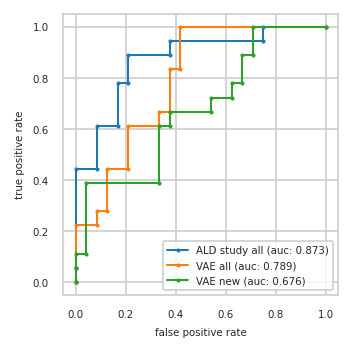

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.444   0.000 0.222   0.000 0.111
3          0.083 0.444   0.083 0.222   0.042 0.111
4          0.083 0.611   0.083 0.278   0.042 0.389
5          0.167 0.611   0.125 0.278   0.333 0.389
6          0.167 0.778   0.125 0.444   0.333 0.611
7          0.208 0.778   0.208 0.444   0.375 0.611
8          0.208 0.889   0.208 0.611   0.375 0.667
9          0.375 0.889   0.333 0.611   0.542 0.667
10         0.375 0.944   0.333 0.667   0.542 0.722
11         0.750 0.944   0.375 0.667   0.625 0.722
12         0.750 1.000   0.375 0.833   0.625 0.778
13         1.000 1.000   0.417 0.833   0.667 0.778
14           NaN   NaN   0.417 1.000   0.667 0.889
15           NaN   NaN   1.000 1.000   0.708 0.889
16           NaN   NaN     NaN   NaN   0.708 1.000
17           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,P31946;P31946-2,Q9HAT2,P16519;P16519-3
2,P09960;P09960-4,P10745,Q96GD0
3,P04075,P25189;P25189-2,Q9NUQ9
4,P61981,P61981,P31321
5,C9JF17;P05090,P10636-2;P10636-6,P31150
6,Q6EMK4,P14174,E9PK25;G3V1A4;P23528
7,None,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,None,Q14894,A0A075B7B8


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


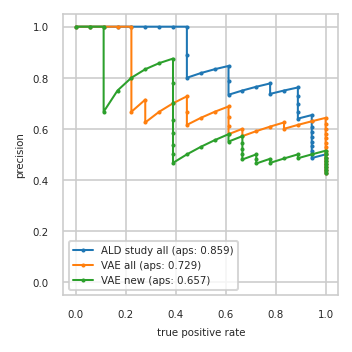

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.485 0.889
10         0.531 0.944     0.562 1.000     0.500 0.889
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.467 0.778
13         0.586 0.944     0.621 1.000     0.483 0.778
14         0.607 0.944     0.643 1.000     0.464 0.722
15         0.630 0.944     0.630 0.944     0.481 0.722
16         0.654 0.944     0.615 0.889     0.500 0.722
17         0.640 0.889     0.600 0.833     0.480 0.667
18         0.667 0.889     0.625 0.833     0.500 0.667
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.727 0.889     0.591 0.722     0.545 0.667
21         0.762 0.889     0.571 0.667     0.571 0.667
22         0.750 0.833     0.600 0.667     0.550 0.611
23         0.737 0.778     0.579 0.611     0.579 0.611
24         0.778 0.778     0.611 0.611     0.556 0.556
25         0.765 0.722     0.647 0.611     0.529 0.500
26         0.750 0.667     0.688 0.611     0.500 0.444
27         0.733 0.611     0.667 0.556     0.467 0.389
28         0.786 0.611     0.643 0.500     0.500 0.389
29         0.846 0.611     0.615 0.444     0.538 0.389
30         0.833 0.556     0.667 0.444     0.583 0.389
31         0.818 0.500     0.727 0.444     0.636 0.389
32         0.800 0.444     0.700 0.389     0.700 0.389
33         0.889 0.444     0.667 0.333     0.778 0.389
34         1.000 0.444     0.625 0.278     0.875 0.389
35         1.000 0.389     0.714 0.278     0.857 0.333
36         1.000 0.333     0.667 0.222     0.833 0.278
37         1.000 0.278     0.800 0.222     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


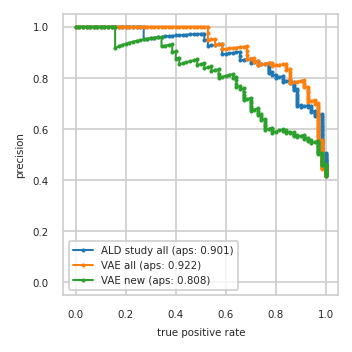

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


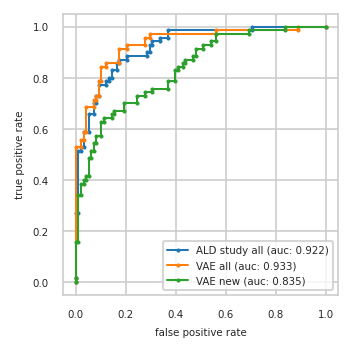

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}